## BERT Tiny

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/8


100%|██████████| 338/338 [02:12<00:00,  2.55it/s]

Average Train Loss: 1.2402


Average Test Loss: 0.9604
Test Accuracy: 0.7112
Epoch 2/8


100%|██████████| 338/338 [01:37<00:00,  3.46it/s]

Average Train Loss: 0.9692


Average Test Loss: 0.7184
Test Accuracy: 0.7660
Epoch 3/8


100%|██████████| 338/338 [01:29<00:00,  3.76it/s]


Average Train Loss: 0.8610
Average Test Loss: 0.6183
Test Accuracy: 0.7827
Epoch 4/8


100%|██████████| 338/338 [01:32<00:00,  3.67it/s]

Average Train Loss: 0.7909


Average Test Loss: 0.5711
Test Accuracy: 0.7888
Epoch 5/8


100%|██████████| 338/338 [01:37<00:00,  3.48it/s]

Average Train Loss: 0.7192


Average Test Loss: 0.5517
Test Accuracy: 0.7994
Epoch 6/8


100%|██████████| 338/338 [01:36<00:00,  3.50it/s]

Average Train Loss: 0.6181


Average Test Loss: 0.5422
Test Accuracy: 0.7979
Epoch 7/8


100%|██████████| 338/338 [01:31<00:00,  3.71it/s]

Average Train Loss: 0.4913


Average Test Loss: 0.5352
Test Accuracy: 0.8085
Epoch 8/8


100%|██████████| 338/338 [01:36<00:00,  3.50it/s]

Average Train Loss: 0.3660


Average Test Loss: 0.5847
Test Accuracy: 0.7796


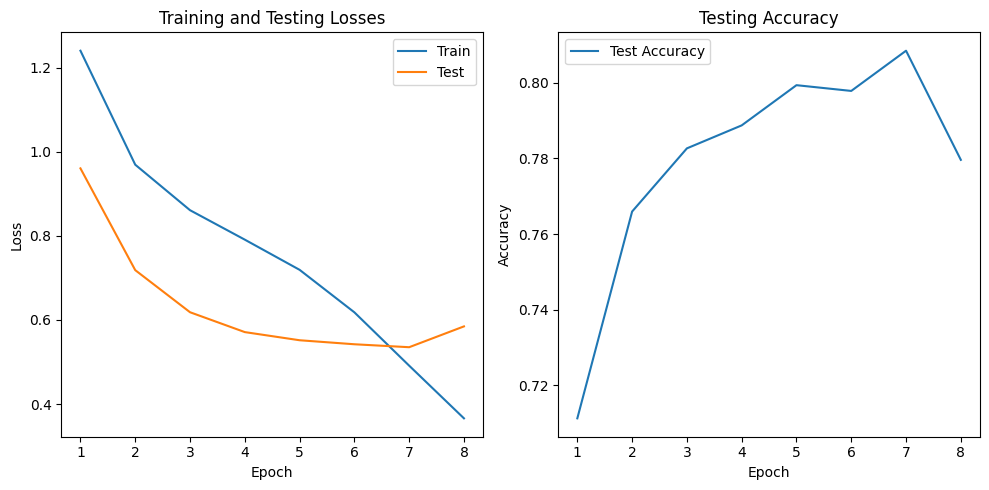

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load your dataset and shuffle if needed
# Assuming shuffled_df contains your data

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=4)

# Tokenize text and encode labels
encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
labels = torch.tensor(df['category_int'].tolist())

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(encoded_data['input_ids'],
                                                                     labels,
                                                                     test_size=0.2,
                                                                     random_state=42)


# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
train_texts_np = train_texts.numpy()
train_labels_np = train_labels.numpy()
train_texts_resampled, train_labels_resampled = smote.fit_resample(train_texts_np, train_labels_np)

# Convert resampled data back to tensors
train_texts_resampled = torch.tensor(train_texts_resampled)
train_labels_resampled = torch.tensor(train_labels_resampled)

# Create DataLoader for training
train_dataset = TensorDataset(train_texts_resampled, train_labels_resampled)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Create DataLoader for testing
test_dataset = TensorDataset(test_texts, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 8
train_losses = []
test_losses = []
test_accuracies = []

model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_train_loss = 0

    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average Train Loss: {avg_train_loss:.4f}")

    # Evaluation on test set
    model.eval()
    epoch_test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(input_ids=inputs)
            loss = criterion(outputs.logits, labels)
            epoch_test_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_test_loss = epoch_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)

        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)
        print(f"Average Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting the training and testing curves
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model to a file
torch.save(model.state_dict(), 'bert_model_small.pth')

In [ ]:
# Load the model from the file
loaded_model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=4)
loaded_model.load_state_dict(torch.load('bert_model_small.pth'))
loaded_model.eval()  # Set the model to evaluation model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-1

In [ ]:
import torch
from torch.nn.functional import softmax

# Example text for evaluation
text = "i have to go to celebrate a festival and have clashes with the class schedule"

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move inputs to the same device as the model (assuming model is on CPU)
inputs = {k: v.to("cpu") for k, v in inputs.items()}

# Ensure the model is also on the CPU
model.to("cpu")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities (you may need to adjust this based on your specific task)
probs = softmax(outputs.logits, dim=1)

# Get the predicted class
predicted_class = torch.argmax(probs, dim=1).item()

# Print the results
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probs.tolist()}")


Predicted class: 2
Class probabilities: [[0.10515139997005463, 0.2720135450363159, 0.5526778101921082, 0.07015722244977951]]
